# bcatの具体的な使用例をここに示す

### <span style="color: red; ">1、モジュールのimport</span>

In [1]:
#bcatをimportする
#sysを使って、bcatがあるディレクトリを指定
import sys
sys.path.append('../../../../../bcat/')
import bcat.io.opu1p85
import bcat

#その他のモジュールのimport
import astropy
import astropy.units as u
import astropy.io.fits as fits
from astropy.wcs import WCS

import numpy as np
import matplotlib.pyplot as plt

### <span style="color: red; ">2、bcat stage1</span>

In [2]:
# データの取得を行う
path = '/1p85m/data4/operation/otf_Cygnus/20210208_225539.necstdb/'
d = bcat.io.opu1p85.opendata(path,vwidth=150,spec='12CO21')

/usr/local/lib/python3.6/dist-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


8
78239


In [3]:
#chopper wheel
Tas,coord_on = d.get_chopper_wheel_spec()

### <span style="color: red; ">3、bcat stage2</span>

In [4]:
# stage2フォーマットに変更
d2_data = bcat.structure.stage2_data(coord=coord_on, spectrum=Tas, rf=d.data.rf)
d2 = bcat.stage2.stage2_container.stage2_container(d2_data)

In [5]:
# どの輝線かを選択 '12CO21'、'12CO32'、'13CO21'、'13CO32'、'C18O21'、'C18O32'
spec = '12CO21'

In [6]:
_12CO21_restfreq = 230.538000*u.GHz
_12CO32_restfreq = 345.795990*u.GHz
_13CO21_restfreq = 220.398684*u.GHz
_13CO32_restfreq = 330.587965*u.GHz
C18O21_restfreq = 219.560358*u.GHz
C18O32_restfreq = 329.330552*u.GHz

In [7]:
co_dic = {'12CO21':_12CO21_restfreq, '12CO32':_12CO32_restfreq, '13CO21':_13CO21_restfreq, '13CO32':_13CO32_restfreq,
         'C18O21':C18O21_restfreq, 'C18O32':C18O32_restfreq}

In [8]:
CO_restfreq = co_dic[spec]

In [9]:
# radec解析か、galactic解析かを選択

world = 'galactic'
# world = 'radec'

In [10]:
beam_size_dic = {'12CO21':180, '12CO32':120, '13CO21':180, '13CO32':120,
         'C18O21':180, 'C18O32':120}

In [11]:
### headerを作成
## このheaderで観測領域のどの範囲をfitsに直すかを決める

hdu = fits.PrimaryHDU()

hdu.header['BITPIX']  =                  -64                                                 
hdu.header['NAXIS']   =                   3                                                 
hdu.header['NAXIS1']  =                   64            #axis1を何ピクセルにするか                                    
hdu.header['NAXIS2']  =                   60            #axis2を何ピクセルにするか
hdu.header['NAXIS3']  =                   480           #axis3を何ピクセルにするか
hdu.header['BPA']     = 0.000000
hdu.header['BMAJ']    = beam_size_dic[spec]/3600                                                  
hdu.header['BMIN']    = beam_size_dic[spec]/3600
hdu.header['BSCALE']  =    1.00000000000E+00                                            
hdu.header['BZERO']   =    0.00000000000E+00  
#hdu.header['EPOCH']   =                 2000                                                                                                    
hdu.header['BUNIT']   = 'K(Ta*)       '                                                                                                    
hdu.header['CTYPE1']  = 'GLON-TAN'              #radec解析か、galactic解析かで変わる radecの場合は、'RA---TAN'                                                
hdu.header['CRVAL1']  =                   81.486  # 中心座標を指定     横軸          
hdu.header['CDELT1']  =                  -beam_size_dic[spec]/3/3600                                                 
hdu.header['CRPIX1']  =                  hdu.header['NAXIS1']/2                                                  
hdu.header['CROTA1']  =                  0.0                                                  
hdu.header['CUNIT1']  = 'deg     ' 

hdu.header['CTYPE2']  = 'GLAT-TAN'              #radec解析か、galactic解析かで変わる radecの場合は、'DEC--TAN'                                              
hdu.header['CRVAL2']  =                  -0.01    # 中心座標を指定   縦軸                      
hdu.header['CDELT2']  =                  beam_size_dic[spec]/3/3600                                                  
hdu.header['CRPIX2']  =                  hdu.header['NAXIS2']/2                                                  
hdu.header['CROTA2']  =                  0.0                                                  
hdu.header['CUNIT2']  = 'deg     '          
hdu.header['CTYPE3']  = 'VELOCITY'                                                            
hdu.header['CRVAL3']  =                  0                            
hdu.header['CDELT3']  =                  500.0                                                  
hdu.header['CRPIX3']  =                  240                                                
hdu.header['CROTA3']  =                  0.0                                                  
hdu.header['CUNIT3']  = 'm/s    ' 

hdu.header['OBJECT']  = 'CYGNUS_X_field'         # objectの名前を決める
hdu.header['RESTFREQ']=           CO_restfreq.value
hdu.header['BUNIT']   = 'K       '           #/ Main Beam Temperature

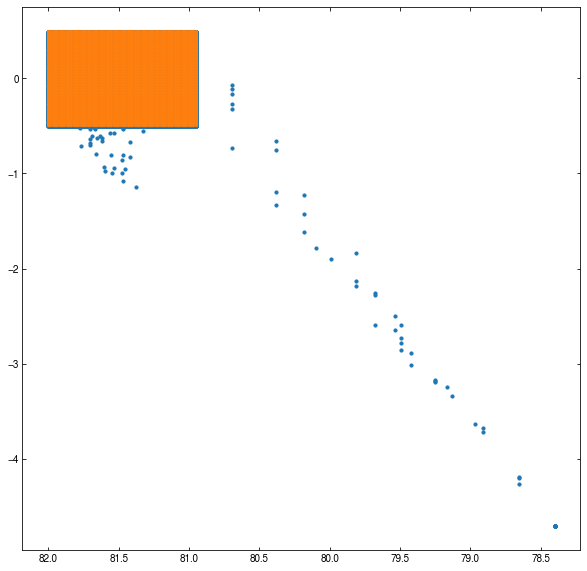

In [12]:
## ここでheaderで書いた情報があっているのかを確認
## 青がon点の座標で、赤がheaderで決めた座標点

w = WCS(hdu.header)
pix_x, pix_y = np.meshgrid(
    np.arange(0,hdu.header['NAXIS1']), 
    np.arange(0, hdu.header['NAXIS2'])
)
center_ra_dec = w.wcs_pix2world(pix_x, pix_y, 0, 0)
center_ra, center_dec = center_ra_dec[0], center_ra_dec[1]
plt.figure(figsize=(10,10))

plt.scatter(d2.data.coord.galactic.l.degree, d2.data.coord.galactic.b.degree, s=10 ,alpha=1)
plt.scatter(center_ra.ravel(), center_dec.ravel(),s=5)
plt.gca().invert_xaxis()

In [13]:
# headerで作成した速度方向の指定値を作成
_, _, target_v = w.wcs_pix2world(0, 0, np.arange(w.array_shape[0]), 0)
target_v = target_v*u.m/u.s

### <span style="color: red; ">4、imaging</span>

In [14]:
# 速度方向のをregridする
image = bcat.stage2.imaging.speed()

In [15]:
#　速度の補正値を作成
v_correction = image.calc_v_correction(base_data=d2, 
                                 loc_lon=138.472153, 
                                 loc_lat=35.940874, 
                                 loc_height=1386)

In [16]:
## 速度方向のregrid後の値
thinned_list = image.speed_imaging(base_data=d2, 
                               target_velocity = target_v, 
                               v_corre = v_correction, 
                               target_freq = CO_restfreq)

### <span style="color: red; ">5、baseline</span>

In [17]:
baseline = bcat.stage2.Baseline_Rms.Baseline_Rms(np.array(thinned_list), target_v)

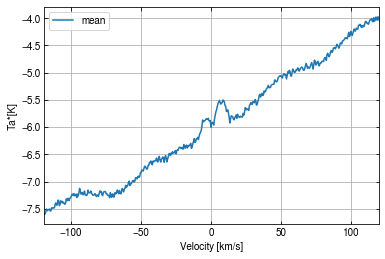

In [18]:
baseline.mean_sp()

In [19]:
# baselineの範囲を決める
baseline.input_fitdata_param_parts([[-120, -70,], [50, 120]])

In [20]:
# baselineのfit関数の次元を決める
baseline.select_func(fit_func=True, order=3)

part :True, clip :False
fit v list : [[-120, -70], [50, 120]]
omega :None, maxiters :None


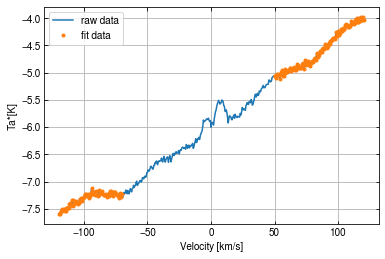

x-func :True, order :3
cheb func :False, deg :None


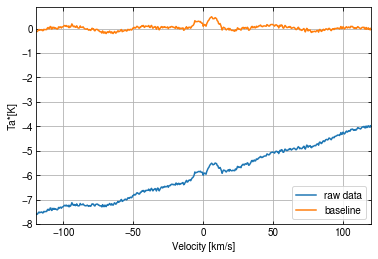

rms : 0.07375447596112239


In [21]:
baseline.sample()

In [22]:
base_rms = baseline.mk_baseline_rms_list()

In [23]:
baseline.mk_mean_rms()

3.541925598188729

In [24]:
thinned_list_base = base_rms[1]
rms_list = base_rms[2]
fit_ch_list = base_rms[3]
# thinned_list_base

### <span style="color: red; ">6、データの成形＋fitsの作成</span>

In [25]:
pix_x, pix_y = np.meshgrid(np.arange(0, hdu.header['NAXIS1']), np.arange(0, hdu.header['NAXIS2']))
center_x_y = w.wcs_pix2world(pix_x, pix_y, 0, 0)
center_x, center_y = center_x_y[0], center_x_y[1]

In [26]:
if world == 'galactic':
    target_x= d2.data.coord.galactic.l
    target_y = d2.data.coord.galactic.b
    
elif world == 'radec':
    target_x= d2.data.coord.ra
    target_y = d2.data.coord.dec
else:
    print('error')

In [27]:
#thinned_list_base_list_listは二次元、rms_list_listは一次元
rere = image.space_regrid(target_x, target_y, 
                              center_x, center_y, 
                              thinned_list_base, rms_list, hdu.header, 
                              kernel_sigma=np.abs(hdu.header['CDELT2'])*u.deg)

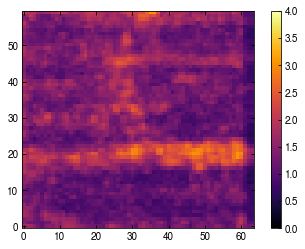

In [28]:
rere1 = np.array(rere)
rere2 = rere1.reshape(hdu.header['NAXIS2'], hdu.header['NAXIS1'] , hdu.header['NAXIS3'])
peak = np.max(rere2[:, :, :], axis=2)
peak[peak == 0] = np.nan
plt.imshow(peak, origin='lower', vmin=0, vmax=4)
# plt.xlim(0,20)
# plt.ylim(30, 40)
plt.colorbar()
#最終的にv, y, x

In [29]:
rere3 = np.swapaxes(rere2, 1, 2)
rere4 = np.swapaxes(rere3, 0, 1)

In [30]:
new_hdu = astropy.io.fits.PrimaryHDU(rere4, hdu.header)
new_hdu_list = astropy.io.fits.HDUList([new_hdu])
new_hdu_list.writeto('new_bcat_%s_%s_%s.fits'%(hdu.header['OBJECT'], spec, path.split('/')[-2].split('.')[0]), overwrite=True)
#天体_輝線_観測日
#上記の保存名はテンプレート

### <span style="color: red; ">7、rmsマップの作成</span>

In [ ]:
rere5 = copy.deepcopy(rere4)
rere5 = np.concatenate([rere5[fit_ch_list]], axis=0)
rms_map = np.std(rere5, axis=0)

In [ ]:
plt.imshow(rms_map, vmin=0, vmax=1)
plt.colorbar()

In [ ]:
rms_header = copy.deepcopy(hdu.header)
rms_header.pop('NAXIS3')
rms_header.pop('CTYPE3')
rms_header.pop('CRVAL3')
rms_header.pop('CDELT3')
rms_header.pop('CRPIX3')
rms_header.pop('CROTA3')
rms_header.pop('CUNIT3')
rms_header.update(NAXIS=2)

In [ ]:
new_hdu_rms = astropy.io.fits.PrimaryHDU(rms_map, rms_header)
new_hdu_list_rms = astropy.io.fits.HDUList([new_hdu_rms])
new_hdu_list_rms.writeto('%s/%s_%s_%s_RMS.fits'%(path.split('/')[-2].split('.')[0], rms_header['OBJECT'], spec, path.split('/')[-2].split('.')[0]), 
                         overwrite=True)